In [ ]:
# !pip install tensorflow
# !pip install Keras


In [ ]:
import os
from shutil import copyfile
import shutil
import sys
from pycocotools.coco import COCO
import urllib
import zipfile
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/Market-1501-v15.09.15.zip

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Data Structure And Algorithm/data.zip','r') as zip_ref:
    zip_ref.extractall()

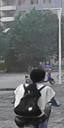

In [ ]:
from google.colab.patches import cv2_imshow
# import cv2
from skimage import io
img_path = "/content/data/bounding_box_test/-1_c1s1_000401_03.jpg"
image = io.imread(img_path)
cv2_imshow(image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

In [ ]:
import glob
import torch

In [ ]:
# general purpose functions.Tensor to numpy convertot and vice-versa

def get_image_id(imname):
    return int(imname.split('_')[0])

def get_image_cam(imname):
    cam_str = imname.split('_')[1][1:]  # Extract the numeric part of the camera string
    cam_str = ''.join(filter(str.isdigit, cam_str))  # Filter out non-numeric characters
    return int(cam_str)


def to_numpy(tensor):
    if torch.is_tensor(tensor):
        return tensor.cpu().numpy()
    elif type(tensor).__module__ != 'numpy':
        raise ValueError("Cannot convert {} to numpy array ".format(type(tensor)))

    return tensor


In [ ]:
def to_torch(ndarray):
    if type(ndarray).__module__ == 'numpy':
        return torch.from_numpy(ndarray)
    elif not torch.is_tensor(ndarray):
        raise ValueError("Cannot convert {} to torch tensor".formar(type(ndarray)))

    return ndarray

In [ ]:
# https://github.com/Cysu/open-reid/blob/master/reid/evaluation_metrics/ranking.py

from collections import defaultdict

import numpy as np
from sklearn.metrics import average_precision_score


def _unique_sample(ids_dict, num):
    mask = np.zeros(num, dtype=np.bool)
    for _, indices in ids_dict.items():
        i = np.random.choice(indices)
        mask[i] = True
    return mask


def cmc(distmat, query_ids=None, gallery_ids=None,
        query_cams=None, gallery_cams=None, topk=100,
        separate_camera_set=False,
        single_gallery_shot=False,
        first_match_break=False):
    distmat = to_numpy(distmat)
    m, n = distmat.shape
    # Fill up default values
    if query_ids is None:
        query_ids = np.arange(m)
    if gallery_ids is None:
        gallery_ids = np.arange(n)
    if query_cams is None:
        query_cams = np.zeros(m).astype(np.int32)
    if gallery_cams is None:
        gallery_cams = np.ones(n).astype(np.int32)
    # Ensure numpy array
    query_ids = np.asarray(query_ids)
    gallery_ids = np.asarray(gallery_ids)
    query_cams = np.asarray(query_cams)
    gallery_cams = np.asarray(gallery_cams)
    # Sort and find correct matches
    indices = np.argsort(distmat, axis=1)
    matches = (gallery_ids[indices] == query_ids[:, np.newaxis])
    # Compute CMC for each query
    ret = np.zeros(topk)
    num_valid_queries = 0
    for i in range(m):
        # Filter out the same id and same camera
        valid = ((gallery_ids[indices[i]] != query_ids[i]) |
                 (gallery_cams[indices[i]] != query_cams[i]))
        if separate_camera_set:
            # Filter out samples from same camera
            valid &= (gallery_cams[indices[i]] != query_cams[i])
        if not np.any(matches[i, valid]): continue
        if single_gallery_shot:
            repeat = 10
            gids = gallery_ids[indices[i][valid]]
            inds = np.where(valid)[0]
            ids_dict = defaultdict(list)
            for j, x in zip(inds, gids):
                ids_dict[x].append(j)
        else:
            repeat = 1
        for _ in range(repeat):
            if single_gallery_shot:
                # Randomly choose one instance for each id
                sampled = (valid & _unique_sample(ids_dict, len(valid)))
                index = np.nonzero(matches[i, sampled])[0]
            else:
                index = np.nonzero(matches[i, valid])[0]
            delta = 1. / (len(index) * repeat)
            for j, k in enumerate(index):
                if k - j >= topk: break
                if first_match_break:
                    ret[k - j] += 1
                    break
                ret[k - j] += delta
        num_valid_queries += 1
    if num_valid_queries == 0:
        raise RuntimeError("No valid query")
    return ret.cumsum() / num_valid_queries


def mean_ap(distmat, query_ids=None, gallery_ids=None,
            query_cams=None, gallery_cams=None):
    distmat = to_numpy(distmat)
    m, n = distmat.shape
    # Fill up default values
    if query_ids is None:
        query_ids = np.arange(m)
    if gallery_ids is None:
        gallery_ids = np.arange(n)
    if query_cams is None:
        query_cams = np.zeros(m).astype(np.int32)
    if gallery_cams is None:
        gallery_cams = np.ones(n).astype(np.int32)
    # Ensure numpy array
    query_ids = np.asarray(query_ids)
    gallery_ids = np.asarray(gallery_ids)
    query_cams = np.asarray(query_cams)
    gallery_cams = np.asarray(gallery_cams)
    # Sort and find correct matches
    indices = np.argsort(distmat, axis=1)
    matches = (gallery_ids[indices] == query_ids[:, np.newaxis])
    # Compute AP for each query
    aps = []
    for i in range(m):
        # Filter out the same id and same camera
        valid = ((gallery_ids[indices[i]] != query_ids[i]) |
                 (gallery_cams[indices[i]] != query_cams[i]))
        y_true = matches[i, valid]
        y_score = -distmat[i][indices[i]][valid]
        if not np.any(y_true): continue
        aps.append(average_precision_score(y_true, y_score))
    if len(aps) == 0:
        raise RuntimeError("No valid query")
    return np.mean(aps)

In [ ]:
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

'cuda'

In [ ]:
# Trainig part

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import random
import numpy as np

ROOT = './data'

class Market1501TrainVal(Dataset):
    def __init__(self,root,transform=None,batch_size=32,shuffle=True):
        self.root = root
        self.transform = transform
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.split_train_val()

        self.query_ptr = 0
        self.query_done = False
        self.query_ids = [get_image_id(c) for c in self.query_images]
        self.query_cams = [get_image_cam(c) for c in self.query_images]


        self.gallery_ptr = 0
        self.gallery_done = False
        self.query_ids = [get_image_id(c) for c in self.query_images]
        self.query_cams = [get_image_cam(c) for c in self.query_images]


        self.images = self.train_images
        self.person_id_gallery = {}

        for f_image in self.images:
            person_id = int(f_image.split('_')[0])

            if person_id not in self.person_id_gallery.keys():
                self.person_id_gallery[person_id] = {
                    'images': [],
                    'ptr': 0
                }
            self.person_id_gallery[person_id]['images'].append(os.path.join(root, 'bounding_box_train', f_image))

        self.images = [os.path.join(self.root,f_image) for f_image in self.images]
        self.person_id_list = list(self.person_id_gallery.keys())

        self.sample_ptr = 0
        self.epoch_done = False
        self.images_per_id = 4
        if self.shuffle:
            random.shuffle(self.person_id_list)


    def split_train_val(self):
        images = os.listdir(os.path.join(self.root,'bounding_box_train'))
        images.sort()
        images.pop()

        images = np.array(images)
        np.random.shuffle(images)

        ids = np.array([get_image_id(f) for f in images])
        cams = np.array([get_image_cam(f) for f in images])

        unique_ids = np.unique(ids)
        np.random.shuffle(unique_ids)

        train_indices = []
        query_indices = []
        gallery_indices = []

        for unique_id in unique_ids:
            query_indices = []
            indices = np.argwhere(unique_id == ids).flatten()

            unique_cams = np.unique(cams[indices])

            for unique_cam in unique_cams:
                query_indices.append(indices[np.argwhere(unique_cam == cams[indices]).flatten()[0]])
            gallery_indices_ = list(np.setdiff1d(indices, query_indices))


            for query_index in query_indices:
                if len(gallery_indices_) == 0 or len(np.argwhere(cams[query_index] != cams[gallery_indices_]).flatten())==0:
                    query_indices.remove(query_index)
                    gallery_indices_.append(query_index)

            if len(query_indices) == 0:
                continue

            query_indices += list(query_indices)
            gallery_indices += list(gallery_indices_)

            num_selected_ids = 0
            num_selected_ids += 1
            if num_selected_ids >= 100:
                break

        train_indices = np.setdiff1d(range(len(images)), np.hstack([query_indices, gallery_indices]))


        self.train_images = images[train_indices]
        self.query_images = images[query_indices]
        self.gallery_images = images[gallery_indices]

        self.train_images.sort()
        self.query_images.sort()
        self.gallery_images.sort()

    def __len__(self):
        return len(self.images)

    def next_batch(self):
        person_ids = self.person_id_list[self.sample_ptr: self.sample_ptr + self.batch_size]
        labels = []
        image_t = []

        for id in person_ids:
            for _ in range(self.images_per_id):
                ptr = self.person_id_gallery[id]['ptr']
                image = Image.open(self.person_id_gallery[id]['images'][ptr])
                image_t.append(self.transform(image))
                labels.append(id)
                self.person_id_gallery[id]['ptr'] += 1
                if self.person_id_gallery[id]['ptr'] >= len(self.person_id_gallery[id]['images']):
                    self.person_id_gallery[id]['ptr'] = 0

        image_t = torch.stack(image_t)
        labels = torch.tensor(labels,dtype=torch.int32)

        self.sample_ptr += self.batch_size
        if self.sample_ptr >= len(self.person_id_list):
            self.epoch_done = True

        return image_t,labels

    def next_batch_gallery(self):
        images_t = []
        labels_t = []

        for i in range(self.gallery_ptr, min(self.gallery_ptr + self.batch_size,len(self.gallery_images))):
            filename = self.gallery_images[i]
            image = Image.open(os.path.join(self.root,'bounding_box_train',filename))
            if self.transform is not None:
                image = self.transform(image)
            images_t.append(image)
            labels_t.append(int(filename.split('_')[0]))

        self.gallery_ptr += self.batch_size
        if self.gallery_ptr >= len(self.gallery_images):
            self.gallery_ptr = 0
            self.gallery_done = True

        images_t = torch.stack(images_t)
        labels_t = torch.tensor(labels_t).long()

        return images_t,labels_t

    def start_over(self):
        self.epoch_done = False
        self.sample_ptr = 0

        if self.shuffle:
            random.shuffle(self.person_id_list)



In [ ]:
# Testing Part

class Market1501Test(Dataset):
    def __init__(self,root,transform=None,batch_size=32):
        self.root = root
        self.transform = transform
        self.batch_size = batch_size

        gallery_images_ = os.listdir(os.path.join(root,'bounding_box_test'))
        gallery_images_.sort()
        gallery_images_.pop()

        self.gallery_images = []
        for filename in gallery_images_:
            if not filename.startswith('-1'):
                self.gallery_images.append(filename)

        self.gallery_ids = [get_image_id(c) for c in self.gallery_images]
        self.gallery_cams = [get_image_cam(c) for c in self.gallery_images]

        self.gallery_ptr = 0
        self.gallery_done = False

        self.query_images = os.listdir(os.path.join(root,'query'))
        self.query_images.sort()
        self.query_images.pop()

        self.query_ids = [get_image_id(c) for c in self.query_images]
        self.query_cams = [get_image_cam(c) for c in self.query_images]

        self.query_ptr = 0
        self.query_done = False

    def next_batch_gallery(self):
        images_t = []
        labels_t = []

        for i in range(self.gallery_ptr,min(self.gallery_ptr + self.batch_size,len(self.gallery(images)))):
            filename = self.gallery_images[i]
            image = Image.open(os.path.join(self.root,'bounding_box_test',filename))
            if self.transform is not None:
                image = self.transfrom(image)
            images_t.append(image)
            labels_t.append(int(filename.split('_')[0]))

        self.gallery_ptr += self.batch_size
        if self.gallery_ptr >= len(self.gallery_images):
            self.gallery_ptr = 0
            self.gallery_done = True

        images_t = torch.stack(images_t)
        labels_t = torch.tensor(labels_t).long()

        return images_t,labels_t



In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
}

def conv3x3(in_planes,out_planes,strid=1):
    return nn.Conv2d(in_planes,out_planes,kernel_size=3,stride=stride,padding=1,bias= False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self,inplanes,planes,stride=1,downsample=None):
        super(BasicBlock,self).__init__()
        self.conv1 = conc3x3(inplanes,planes,stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes,planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride


    def forward(self,x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

    class Bottleneck(nn.Module):
        expansion = 4

        def __init__(self,inplanes,planes,stride=1,downsample=None):
            super(Bottleneck,self).__init__()
            self.conv1 = nn.Conv2d(inplanes,planes,kernel_size=1,bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.conv2 = nn.Conv2d(planes,planes,kernel_size=3,stride=stride,padding=1,bias=False)
            self.bn2 = nn.BatchNorm2d(planes)
            self.conv2 = nn.Conv3d(planes,planes * 4,kernel_size=1,bias=False)
            self.bn3 = nn.BatchNorm2d(planes * 4)
            self.relu = nn.ReLU(inplace=True)
            self.downsample = downsample
            self.stride = stride

        def forward(self,x):
            residual = x

            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)

            out = self.conv2(x)
            out = self.bn2(out)
            out = self.relu(out)

            out = self.conv3(x)
            out = self.bn3(out)

            if self.downsample is not None:
                residual = self.downsample(x)

            out += residual
            out = self.relu(out)
            return out


    class ResNet(nn.Module):

        def __init__(self,block,layers,last_conv_stride=2):

            self.inplanes = 64
            super(ResNet,self).__init__()
            self.conv1 = nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False)
            self.bn1 = nn.BatchNorm2d(64)
            self.relu = nn.ReLU(inplace=True)
            self.maxpool = nn.MaxPool2d(kernel_size=7,stride=2,padding=3,bias=False)
            self.bn1 = nn.BatchNorm2d(64)
            self.relu = nn.ReLU(inplace=True)
            self.layer1 = self._make_layer(block,64,layers[0])
            self.layer2 = self._make_layer(block,128,layers[1],stride=2)
            self.layer3 = self._make_layer(block,256,layers[2],stride=2)
            self.layer4 = self._make_layer(block,512,layers[3],stride=last_conv_stride)

            for m in self.modules():
                if isinstance(m,nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0,math.sqrt(2. / n))
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()

        def _make_layer(self,block,planes,blocks,stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes * block.expansion:
                downsample = nn.Sequential(
                nn.Conv2d(self.inplanes,planes * block.expansion,kernel_size=1, stride=stride,bias=False),
                nn.BatchNorm2d(planes * block.expansion),
                )
            layers = []
            layers.append(block(self.inplanes,planes,stride,downsample))
            self.inplanes = planes * block.expansion
            for i in range(1,blocks):
                layers.append(block(self.inplanes,planes))

            return nn.Sequential(*layers)

        def forward(self,x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)

            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

            return x

        def remove_fc(state_dict):
            new_state_dict = {}

            for key,value in state_dict.items():
                if not key.startwith('fc.'):
                    new_state_dict[key] = value

            return new_state_dict

        def resnet50(pretrained=False, **kwargs):
            model = ResNet(Bottleneck,[3,4,6,3], **kwargs)
            if pretrained:
                model.load_state_dict(remove_fc(model_zoo,load_url(model_urls['resnet50'])))
            return model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50


class Model(nn.Module):
    def __init__(self,last_conv_stride=2,local_conv_out_channels=128):
        super(Model, self).__init__()
        self.base = resnet50(pretrained=True)
        modules = list(self.base.children())[:-2]
        modules[-1][0].conv2.stride = (1, 1)
        modules[-1][0].downsample[0].stride = (1, 1)
        self.base = nn.Sequential(*modules)
        self.local_feat_extractor = nn.Sequential(
        nn.Conv2d(2048,local_conv_out_channels,1),
        nn.BatchNorm2d(local_conv_out_channels),
        nn.ReLU(inplace=True))

    def forward(self,x):
        feat = self.base(x)
        global_feat = F.avg_pool2d(feat, feat.size()[2:])
        global_feat = global_feat.view(x.size(0), -1)


        local_feat = torch.mean(feat,-1,keepdim=True)
        local_feat = self.local_feat_extractor(local_feat)

        local_feat = local_feat.squeeze(-1).permute(0,2,1)

        return global_feat, local_feat


# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision.models import resnet50


# class Model(nn.Module):
#     def __init__(self,last_conv_stride=2,local_conv_out_channels=128):
#         super(Model,self).__init__()
#         self.base = resnet50(pretrained=True)
#         # self.base = resnet50(pretrained=True, last_conv_stride=last_conv_stride)

#         self.local_feat_extractor = nn.Sequential(
#             nn.Conv2d(2048,local_conv_out_channels,1),
#             nn.BatchNorm2d(local_conv_out_channels),
#             nn.ReLU(inplace=True)
#             )

#     def forward(self,x):
#       # Shape [N, C, H, W]
#         feat = self.base(x)
#         global_feat = F.avg_pool2d(feat,feat.size()[2:])
#         #shape [N,C,H,1]
#         global_feat = global_feat.view(feat.size(0), -1)

#         #shape [N,C,H,1]
#         local_feat = torch.mean(feat,-1,keepdim=True)
#         local_feat = self.local_feat_extractor(local_feat)

#         #shape [N, H, c]
#         local_feat = local_feat.squeeze(-1).permute(0,2,1)

#         return global_feat, local_feat


In [ ]:
# loss function
import torch
from torch import nn
from torch.autograd import Variable


class TripletLoss(object):
    def __init__(self, margin=None):
        self.margin = margin
        if margin is not None:
            self.ranking_loss = nn.MarginRankingLoss(margin=margin)
        else:
            self.ranking_loss = nn.SoftMarginLoss()

    def __call__(self, dist_ap,dist_an):
        if dist_an.numel() == 0:
            raise ValueError("dist_an is empty. There might be an issue in your code.")

        y = torch.ones_like(dist_an)

        # y = Variable(dist_an.data.new().resize_as(dist_an.data).fill_(1))
        if self.margin is not None:
            loss = self.ranking_loss(dist_an,dist_ap,y)
        else:
            loss = self.ranking_loss(dist_an - dist_ap,y)
        return loss

In [ ]:
# Euclidean distance function

def euclidean_dist(x,y):
    m,n = x.size(0),y.size(0)
    xx = torch.pow(x,2).sum(1,keepdim=True).expand(m,n)
    yy = torch.pow(y,2).sum(1,keepdim=True).expand(n,m).t()
    dist = xx + yy
    # dist = torch.addmm(1, dist, -2, x, y.t())
    dist.addmm(1,-2,x,y.t())
    dist = dist.clamp(min=1e-12).sqrt()
    return dist

# def euclidean_dist(x, y):
#     m, n = x.size(0), y.size(0)
#     xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
#     yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
#     dist = xx + yy
#     dist = torch.addmm(1, dist, -2, x, y.t())  # Use addmm without in-place operation
#     dist = dist.clamp(min=1e-12).sqrt()
#     return dist

# def shortest_dist(dist_mat):
#     m, n = dist_mat.size()[:2]
#     dist = [[0 for _ in range(n)] for _ in range(m)]
#     for i in range(m):
#         for j in range(n):
#             if (i == 0) and (j == 0):
#                 dist[i][j] = dist_mat[i, j]
#             elif (i == 0) and (j > 0):
#                 dist[i][j] = dist[i][j-1] + dist_mat[i,j]
#             elif (i > 0) and (j == 0):
#                 dist[i][j] = dist[i - 1][j] + dist_mat[i, j]
#             else:
#                 dist[i][j] = torch.min(dist[i - 1][j],dist[i][j - 1])+ dist_mat[i][j]
#         dist = dist[-1][-1]
#         return dist

def shortest_dist(dist_mat):
    m, n = dist_mat.size()[:2]
    dist = [[0 for _ in range(n)] for _ in range(m)]
    for i in range(m):
        for j in range(n):
            if (i == 0) and (j == 0):
                dist[i][j] = dist_mat[i, j]
            elif (i == 0) and (j > 0):
                dist[i][j] = dist[i][j-1] + dist_mat[i, j]
            elif (i > 0) and (j == 0):
                dist[i][j] = dist[i - 1][j] + dist_mat[i, j]
            else:
                dist[i][j] = torch.min(dist[i - 1][j], dist[i][j - 1]) + dist_mat[i][j]

    # Convert the dist list to a tensor
    dist = torch.tensor(dist, dtype=dist_mat.dtype, device=dist_mat.device)
    return dist[-1, -1]











# def local_dist(x,y):
#     M, m, d = x.size()
#     N, n, d = y.size()
#     x = x.contiguous().view(M * m,d)
#     y = y.contiguous().view(N * n,d)

#     dist_mat = euclidean_dist(x,y)
#     dist_mat = (torch.exp(dist_mat)-1.)/(torch.exp(dist_mat)+ 1.)

#     dist_mat = dist_mat.contiguous().view(M,m,N,n).permute(1,3,0,2)

#     dist_mat = shortest_dist(dist_mat)

#     return dist_mat

# def local_dist(x, y):
#     M, m, d = x.size()
#     N, n, d = y.size()
#     x = x.contiguous().view(M * m, d)
#     y = y.contiguous().view(N * n, d)

#     dist_mat = euclidean_dist(x, y)
#     dist_mat = (torch.exp(dist_mat) - 1.) / (torch.exp(dist_mat) + 1.)

#     dist_mat = dist_mat.contiguous().view(M, m, N, n).permute(1, 3, 0, 2)

#     # Compute the shortest distance directly without using the shortest_dist function
#     dist = dist_mat.clone()
#     for i in range(m):
#         for j in range(n):
#             if (i > 0) and (j > 0):
#                 dist[i, j] += torch.min(dist[i - 1, j], dist[i, j - 1])
#             elif (i == 0) and (j > 0):
#                 dist[i, j] += dist[i, j - 1]
#             elif (i > 0) and (j == 0):
#                 dist[i, j] += dist[i - 1, j]

#     return dist[-1, -1]

def local_dist(x, y):
    M, m, d = x.size()
    N, n, d = y.size()
    x = x.contiguous().view(M * m, d)
    y = y.contiguous().view(N * n, d)

    dist_mat = euclidean_dist(x, y)
    dist_mat = (torch.exp(dist_mat) - 1.) / (torch.exp(dist_mat) + 1.)

    dist_mat = dist_mat.contiguous().view(M, m, N, n).permute(1, 3, 0, 2)

    # Compute the shortest distance directly without using the shortest_dist function
    dist = dist_mat.clone()  # Create a new tensor to accumulate values
    for i in range(m):
        for j in range(n):
            if (i > 0) and (j > 0):
                dist[i, j] = dist_mat[i, j] + torch.min(dist[i - 1, j], dist[i, j - 1])
            elif (i == 0) and (j > 0):
                dist[i, j] = dist_mat[i, j] + dist[i, j - 1]
            elif (i > 0) and (j == 0):
                dist[i, j] = dist_mat[i, j] + dist[i - 1, j]

    return dist[-1, -1]

# def hard_example_mining(dist_mat, labels):
#     assert len(dist_mat.size()) == 2
#     assert dist_mat.size(0) == dist_mat.size(1)
#     N = dist_mat.size(0)

#     is_pos = labels.expand(N, N).eq(labels.expand(N, N).t())
#     is_neg = labels.expand(N, N).ne(labels.expand(N, N).t())

#     dist_ap, relative_p_inds = torch.max(
#         dist_mat[is_pos].contiguous().view(N, -1), 1, keepdim=True)

#     dist_ap = dist_ap.squeeze(1)

#     # Fix the variable assignment here
#     dist_an, relative_n_inds = torch.min(
#         dist_mat[is_neg].contiguous().view(N, -1), 1, keepdim=True)

#     dist_an = dist_an.squeeze(1)

#     return dist_ap, dist_an
def hard_example_mining(dist_mat, labels):
    assert len(dist_mat.size()) == 2
    assert dist_mat.size(0) == dist_mat.size(1)
    N = dist_mat.size(0)

    is_pos = labels.expand(N, N).eq(labels.expand(N, N).t())
    is_neg = labels.expand(N, N).ne(labels.expand(N, N).t())

    dist_ap, relative_p_inds = torch.max(
        dist_mat[is_pos].contiguous().view(N, -1), 1, keepdim=True)

    dist_ap = dist_ap.squeeze(1)

    # Set a default value for dist_an
    dist_an = torch.zeros_like(dist_ap)

    # Update dist_an if there are negative samples
    if torch.any(is_neg):
        dist_an, relative_n_inds = torch.min(
            dist_mat[is_neg].contiguous().view(N, -1), 1, keepdim=True)

        dist_an = dist_an.squeeze(1)

    return dist_ap, dist_an



# def hard_example_mining(dist_mat,labels):
#     assert len(dist_mat.size()) == 2
#     assert dist_mat.size(0) == dist_mat.size(1)
#     N = dist_mat.size(0)

#     is_pos = labels.expand(N,N).eq(labels.expand(N,N).t())
#     is_neg = labels.expand(N,N).ne(labels.expand(N,N).t())

#     dist_ap,relative_p_inds = torch.max(
#     dist_mat[is_pos].contiguous().view(N,-1),1,keepdim=True)

#     dist_ap = dist_ap.squeeze(1)
#     dist_an = dist_an.squeeze(1)

#     return dist_ap,dist_an

def global_loss(tri_loss,global_feat,labels):
    dist_mat = euclidean_dist(global_feat,global_feat)
    dist_ap,dist_an = hard_example_mining(dist_mat,labels)
    loss = tri_loss(dist_ap,dist_an)

    return loss, dist_ap, dist_an

def local_loss(tri_loss,local_feat,labels):
    dist_mat = local_dist(local_feat,local_feat)
    # dist_mat = 10
    dist_ap,dist_an = hard_example_mining(dist_mat,labels)
    loss = tri_loss(dist_ap,dist_an)

    return loss,dist_ap,dist_an


In [ ]:
# validation

def valid(model, dataset):
    model.eval()


    total_query_features = []
    total_query_labels = []

    query_feat = []
    dataset.query_done = False
    dataset.query_ptr = 0

    while not dataset.query_done:
        image_t,labels_t = dataset.next_batch_query()
        if images_t is None or labels_t is None:
            break

        images_t = images_t.to(DEVICE)
        with torch.no_grad():
          feat, _ = model(images_t)

        total_query_features.append(feat)
        tota;_query_labels.append(labels_t)

        query_feat.append(feat.cpu().detach())

    query_feat = torch.cat(query_feat)

    gallery_feat = []
    dataset.gallery_done = False
    dataset.gallery_ptr = 0

    while not dataset.gallery_done:
        images_t,labels_t = dataset.next_batch_gallery()
        images_t = images_t.to(DEVICE)
        feat, _ = model(images_t)
        query_feat.append(feat.cpu().detach())

    gallery_feat = torch.cat(gallery_feat)

    # calculate distance
    dist_mat = euclidean_dist(query_feat,gallery_feat)

    cmc_score = cmc(dist_mat,dataset.query_ids,dataset.gallery_ids,dataset.query_cams,dataset.gallery_cams,topk=5,separate_camera_set=False,single_gallery_shot=False,first_match_break=True)

    # calculate average precision
    mAP = mean_ap(dist_mat,dataset.query_ids,dataset.gallery_ids,dataset.query_cams,dataset.gallery_cams)

    model.train()
    return mAP,cmc_score

In [ ]:
# Configuration

n_epochs = 2

g_margin = 0.3
g_loss_weight = 0.5

l_margin = 0.3
l_loss_weight = 0.5

batch_size = 32

In [ ]:
# Prepare for Training
transform = transforms.Compose([
    transforms.ToTensor(),

    transforms.Resize([256,128]),

    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

market1501 = Market1501TrainVal(ROOT,transform,batch_size=batch_size)

In [ ]:
# Adam Optimizer Use
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
model = Model(last_conv_stride=1)
cur_epoch = 0

g_tri_loss = TripletLoss(g_margin)
l_tri_loss = TripletLoss(l_margin)
optimizer = Adam(model.parameters(),lr=2e-4,weight_decay=0.0005)
scheduler = StepLR(optimizer,step_size=100,gamma=0.1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 57.7MB/s]


In [ ]:
# Start training

import numpy as np
from torch.autograd import Variable
import time

print(f'number of person-ids for training: {len(market1501.person_id_list)}')
print(f'number of training images: {len(market1501.train_images)}')
print(f'number of query images for validation: {len(market1501.query_images)}')
print(f'number of gallery images for validation: {len(market1501.gallery_images)}')

model.train()


for epoch in range(cur_epoch,n_epochs):
    torch.autograd.set_detect_anomaly(True)
    print(f'epoch:{epoch}')
    market1501.start_over()

    total_loss = []
    total_g_loss = []
    total_g_prec = []
    total_g_sm = []
    total_g_dist_ap = []
    total_g_dist_an = []

    total_l_loss = []
    total_l_prec = []
    total_l_sm = []
    total_l_dist_ap = []
    total_l_dist_an = []

    iter = 0
    t_now = time.time()


    while not market1501.epoch_done:
        images_t, labels_t = market1501.next_batch()
        images_t = Variable(images_t)

        g_feat, l_feat = model(images_t)

        g_loss,g_dist_ap,g_dist_an = global_loss(g_tri_loss,g_feat,labels_t)
        l_loss,l_dist_ap, l_dist_an = local_loss(l_tri_loss, l_feat ,labels_t)

        loss = g_loss_weight * g_loss + l_loss_weight * l_loss

        optimizer.zero_grad()
        # loss.backward()
        optimizer.step()


        total_loss.append(loss.item())

        total_g_loss.append(g_loss.item())
        total_g_prec.append((g_dist_an > g_dist_ap).data.float().mean().item())
        total_g_sm.append((g_dist_an > g_dist_ap + g_margin).data.float().mean().item())
        total_g_dist_ap.append(g_dist_ap.data.float().mean().item())
        total_g_dist_an.append(g_dist_an.data.float().mean().item())

        total_l_loss.append(l_loss.item())
        total_l_prec.append((l_dist_an > l_dist_ap).data.float().mean().item())
        total_l_sm.append((l_dist_an > l_dist_ap + l_margin).data.float().mean().item())
        total_l_dist_ap.append(l_dist_ap.data.float().mean().item())
        total_l_dist_an.append(l_dist_an.data.float().mean().item())

        iter +=1
    print(f'in {(time.time() - t_now)}s')
    print(f'mean_loss = {np.mean(total_loss)}, mean_g_loss = {np.mean(total_g_loss)}, mean_l_loss = {np.mean(total_l_loss)}')
    print(f'mean_g_prec = {np.mean(total_g_prec)}, mean_l_prec = {np.mean(total_l_prec)}')
    print(f'mean_g_sm = {np.mean(total_g_sm)}, mean_l_sm = {np.mean(total_l_sm)}')
    print(f'mean_g_dist_ap = {np.mean(total_g_dist_ap)}, mean_l_dist_ap = {np.mean(total_l_dist_ap)}')
    # print(f'mean_g_dist_ap = {np.mean(total_dist_ap)}, mean_l_dist_ap = {np.mean(total_l_dist_ap)}')
    print(f'mean_g_dist_an = {np.mean(total_g_dist_an)}, mean_l_dist_an = {np.mean(total_l_dist_an)}')
    # print(f'mean_g_dist_an = {np.mean(total_dist_an)}, mean_l_dist_an = {np.mean(total_l_dist_an)}')
    print(f'learning_rate = {scheduler.get_last_lr()}')

    scheduler.step()

    if(epoch + 1) % 2 == 0:
        mAP,cmc_score = valid(model,market1501)
        print(f'-----------------------------------')
        print(f'validation: mAP={mAP}, rank1={cmc_score[0]},rank5={cmc_score[4]}')
        print(f'-----------------------------------')

    if(epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        },f'checkpoint_s1_{epoch+1}.pth')



number of person-ids for training: 10
number of training images: 43
number of query images for validation: 2
number of gallery images for validation: 155
epoch:0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-16-18001ddd3432>:9: UserWarning: This overload of addmm is deprecated:
	addmm(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internall

in 10.560121774673462s
mean_loss = 1.9257081747055054, mean_g_loss = 3.546273708343506, mean_l_loss = 0.3051425516605377
mean_g_prec = 0.0, mean_l_prec = 0.0
mean_g_sm = 0.0, mean_l_sm = 0.0
mean_g_dist_ap = 34.86772537231445, mean_l_dist_ap = 30.996337890625
mean_g_dist_an = 31.621450424194336, mean_l_dist_an = 30.991199493408203
learning_rate = [0.0002]
epoch:1
in 9.446252346038818s
mean_loss = 1.9568302631378174, mean_g_loss = 3.608870267868042, mean_l_loss = 0.304790198802948
mean_g_prec = 0.0, mean_l_prec = 0.0
mean_g_sm = 0.0, mean_l_sm = 0.0
mean_g_dist_ap = 35.076385498046875, mean_l_dist_ap = 30.99624252319336
mean_g_dist_an = 31.76751708984375, mean_l_dist_an = 30.9914493560791
learning_rate = [0.0002]


AttributeError: ignored

In [ ]:
# # Start training

# import numpy as np
# from torch.autograd import Variable
# import time

# print(f'number of person-ids for training: {len(market1501.person_id_list)}')
# print(f'number of training images: {len(market1501.train_images)}')
# print(f'number of query images for validation: {len(market1501.query_images)}')
# print(f'number of gallery images for validation: {len(market1501.gallery_images)}')

# model.train()

# for epoch in range(cur_epoch,n_epochs):
#     torch.autograd.set_detect_anomaly(True)
#     print(f'epoch:{epoch}')
#     market1501.start_over()

#     total_loss = []
#     total_g_loss = []
#     total_g_prec = []
#     total_g_sm = []
#     total_g_dist_ap = []
#     total_g_dist_an = []

#     total_l_loss = []
#     total_l_prec = []
#     total_l_sm = []
#     total_l_dist_ap = []
#     total_l_dist_an = []

#     iter = 0
#     t_now = time.time()
#     while not market1501.epoch_done:
#     # while not market1501.query_done:

#         # images_t, labels_t = market1501.next_batch()
#         # image_t, labels_t = market1501.get_query_batch()
#         # image_t, labels_t = market1501.get_validation_query_batch()
#         query_image_t, query_labels_t = market1501.get_validation_query_batch()
#         gallery_image_t, gallery_labels_t = market1501.get_validation_gallery_batch()

#         query_images_t = query_image_t.to(DEVICE)
#         gallery_images_t = gallery_image_t.to(DEVICE)

#         query_feat, _ = model(query_images_t)
#         gallery_feat, _ = model(gallery_images_t)

#         # images_t = Variable(images_t)

#         # g_feat, l_feat = model(images_t)
#         g_loss,g_dist_ap,g_dist_an = global_loss(g_tri_loss,gallery_feat,query_labels_t)
#         l_loss,l_dist_ap, l_dist_an = local_loss(l_tri_loss, _ ,query_labels_t)


#         # g_loss,g_dist_ap,g_dist_an = global_loss(g_tri_loss,g_feat,labels_t)
#         # l_loss,l_dist_ap, l_dist_an = local_loss(l_tri_loss,l_feat,labels_t)

#         loss = g_loss_weight * g_loss + l_loss_weight * l_loss

#         optimizer.zero_grad()
#         # loss.backward()
#         optimizer.step()


#         total_loss.append(loss.item())

#         total_g_loss.append(g_loss.item())
#         total_g_prec.append((g_dist_an > g_dist_ap).data.float().mean().item())
#         total_g_sm.append((g_dist_an > g_dist_ap + g_margin).data.float().mean().item())
#         total_g_dist_ap.append(g_dist_ap.data.float().mean().item())
#         total_g_dist_an.append(g_dist_an.data.float().mean().item())

#         total_l_loss.append(l_loss.item())
#         total_l_prec.append((l_dist_an > l_dist_ap).data.float().mean().item())
#         total_l_sm.append((l_dist_an > l_dist_ap + l_margin).data.float().mean().item())
#         total_l_dist_ap.append(l_dist_ap.data.float().mean().item())
#         total_l_dist_an.append(l_dist_an.data.float().mean().item())

#         iter +=1
#     print(f'in {(time.time() - t_now)}s')
#     print(f'mean_loss = {np.mean(total_loss)}, mean_g_loss = {np.mean(total_g_loss)}, mean_l_loss = {np.mean(total_l_loss)}')
#     print(f'mean_g_prec = {np.mean(total_g_prec)}, mean_l_prec = {np.mean(total_l_prec)}')
#     print(f'mean_g_sm = {np.mean(total_g_sm)}, mean_l_sm = {np.mean(total_l_sm)}')
#     print(f'mean_g_dist_ap = {np.mean(total_g_dist_ap)}, mean_l_dist_ap = {np.mean(total_l_dist_ap)}')
#     # print(f'mean_g_dist_ap = {np.mean(total_dist_ap)}, mean_l_dist_ap = {np.mean(total_l_dist_ap)}')
#     print(f'mean_g_dist_an = {np.mean(total_g_dist_an)}, mean_l_dist_an = {np.mean(total_l_dist_an)}')
#     # print(f'mean_g_dist_an = {np.mean(total_dist_an)}, mean_l_dist_an = {np.mean(total_l_dist_an)}')
#     print(f'learning_rate = {scheduler.get_last_lr()}')

#     scheduler.step()

#     if(epoch + 1) % 2 == 0:
#         mAP,cmc_score = valid(model,market1501)
#         print(f'-----------------------------------')
#         print(f'validation: mAP={mAP}, rank1={cmc_score[0]},rank5={cmc_score[4]}')
#         print(f'-----------------------------------')

#     if(epoch + 1) % 5 == 0:
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#         },f'checkpoint_s1_{epoch+1}.pth')



number of person-ids for training: 10
number of training images: 40
number of query images for validation: 8
number of gallery images for validation: 155
epoch:0


AttributeError: ignored

In [ ]:
torch.save(model.state_dict(), 'model_weight.pth')


In [ ]:
market1501_test = Market1501Test(ROOT,transfrom,batch_size=32)

In [ ]:
model.eval()

query_feat = []
market1501_test.query_done = False
market1501_test.query_ptr = 0

n_images = len(market1501_test.query_images)
print(f'number of query images: {n_images}')

cnt = 0

while not market1501_test.query_done:
    images_t,labels_t = market1501_test.next_batch_query()

    global_feat, local_feat = model(images_t)

    query_feat.append(global_feat.cpu().detach())

query_feat = torch.cat(query_feat)

print('done')


In [ ]:
gallery_feat = []
market1501_test.gallery_done = False
market1501_test.gallery_ptr = 0

n_images = len(market1501_test.gallery_images)
print(f'number of gallery images: {n_images}')

while not market1501_test.gallery_done:
    images_t, labels_t = market1501_test.next_batch_gallery()

    gobal_feat,local_feat = model(images_t)

    gallery_feat.append(gobal_feat.cpu().detach())

gallery_feat = torch.cat(gallery_feat)

print('done')



In [ ]:
# Calculate Distance
dist_mat = euclidean_dist(query_feat,gallery_feat)

In [ ]:
#Calculate Rank-1 and Rank-5

cmc_score = cmc(dist_mat,market1501_test.query_ids,market1501_test.gallery_ids,market1501_test.query_cams,market1501_test.gallery_cams,separate_camera_set=False,sigle_gallery_shot=False,first_match_break=True)
print(f'Rank-1 Score: {cmc_score[0]}')
print(f'Rank-5 Score: {cmc_score[4]}')

In [ ]:
#Calculate mAP(mean Average Precision)
mAP_score = mean_ap(dist_mat,market1501_test.query_ids,market1501_test.gallery_ids,market1501_test.query_cams,market1501_test.gallery_cams)
print(f'mAP score: {mAP_score}')